To download the cell type annotations:
`aws s3 cp s3://openproblems-bio/public/post_competition/openproblems_bmmc_cite_complete.h5ad ./datasets/post_competition/ --no-sign-request`
`aws s3 cp s3://openproblems-bio/public/post_competition/openproblems_bmmc_multiome_complete.h5ad ./datasets/post_competition/ --no-sign-request`


In [ ]:
import os
import anndata as ad
import torch
import numpy
import argparse
import pandas as pd
from tqdm.auto import tqdm

os.getcwd()

In [3]:
# TASK = 'GEX2ADT'
TASK = 'GEX2ATAC'
DATASET_PATH = "datasets"
# PREDICTION_PATH = "pretrain/defaultGEX2ATAC.h5ad"
PREDICTION_PATH = "pretrainNovel/NovelGEX2ATAC.h5ad"

In [4]:
if TASK == 'GEX2ADT':
    test_path = os.path.join(DATASET_PATH, "openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna"
                                                ".censor_dataset.output_")
    completedata_path = os.path.join(DATASET_PATH, "post_competition/openproblems_bmmc_cite_complete.h5ad")
elif TASK == 'GEX2ATAC':
    test_path = os.path.join(DATASET_PATH, "openproblems_bmmc_multiome_phase2_rna"
                                                "/openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_")
    completedata_path = os.path.join(DATASET_PATH, "post_competition/openproblems_bmmc_multiome_complete.h5ad")
else:
    raise ValueError('Unknown task: ' + TASK)

In [5]:
par = {
        "input_mod1": f"{test_path}test_mod1.h5ad",
        "input_mod2": f"{test_path}test_mod2.h5ad",
        "input_complete": completedata_path,
        "input_test_sol": f"{test_path}test_sol.h5ad",
        "input_test_prediction": PREDICTION_PATH,
}

In [6]:
input_mod1 = ad.read_h5ad(par["input_mod1"])
input_mod2 = ad.read_h5ad(par["input_mod2"])
complete = ad.read_h5ad(par["input_complete"])
prediction_test = ad.read_h5ad(par["input_test_prediction"])
sol_test = ad.read_h5ad(par["input_test_sol"])

In [6]:
def obs_fea(adata):
    print(f"The data has {adata.n_obs} observations and {adata.n_vars} features.")

obs_fea(prediction_test)
obs_fea(sol_test)
obs_fea(complete)
obs_fea(input_mod1)
obs_fea(input_mod2)


The data has 20009 observations and 20009 features.
The data has 20009 observations and 20009 features.
The data has 69249 observations and 129921 features.
The data has 20009 observations and 13431 features.
The data has 20009 observations and 116490 features.


In [7]:
input_mod2.obs_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '19999', '20000', '20001', '20002', '20003', '20004', '20005', '20006',
       '20007', '20008'],
      dtype='object', length=20009)

In [8]:
complete

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [7]:
mod1_withcelltype = complete[input_mod1.obs_names]
mod1_withcelltype.obs["cell_type"]

AGCGATTTCATCCTGC-13-s4d1                B1 B
TTGACTAAGGTCAAAG-13-s4d1       Naive CD20+ B
AGGAACGGTGAGGTGA-13-s4d1        Erythroblast
TAGGGTTTCCGTGACA-13-s4d1    CD4+ T activated
GGTCTTGAGGCATGTT-13-s4d1          CD14+ Mono
                                  ...       
AAACCGCGTTTGAGGC-12-s4d9        CD8+ T naive
TGACTTAAGTTCCCGT-12-s4d9          Lymph prog
GCTGTACCACCGTTCC-12-s4d9              CD8+ T
ACACTTGCAACTAGAA-12-s4d9                cDC2
CACTTAAAGTCTGGGC-12-s4d9       Naive CD20+ B
Name: cell_type, Length: 20009, dtype: category
Categories (20, object): ['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', ..., 'Proerythroblast', 'Transitional B', 'cDC2', 'pDC']

In [8]:
celltypes = mod1_withcelltype.obs["cell_type"].cat.categories.tolist()

In [9]:
celltypes

['B1 B',
 'CD4+ T activated',
 'CD4+ T naive',
 'CD8+ T',
 'CD8+ T naive',
 'CD14+ Mono',
 'CD16+ Mono',
 'Erythroblast',
 'G/M prog',
 'HSC',
 'Lymph prog',
 'MK/E prog',
 'NK',
 'Naive CD20+ B',
 'Normoblast',
 'Plasma cell',
 'Proerythroblast',
 'Transitional B',
 'cDC2',
 'pDC']

In [10]:
celltype2idx = dict([(celltype, idx) for idx, celltype in enumerate(celltypes)])
celltype2idx

{'B1 B': 0,
 'CD4+ T activated': 1,
 'CD4+ T naive': 2,
 'CD8+ T': 3,
 'CD8+ T naive': 4,
 'CD14+ Mono': 5,
 'CD16+ Mono': 6,
 'Erythroblast': 7,
 'G/M prog': 8,
 'HSC': 9,
 'Lymph prog': 10,
 'MK/E prog': 11,
 'NK': 12,
 'Naive CD20+ B': 13,
 'Normoblast': 14,
 'Plasma cell': 15,
 'Proerythroblast': 16,
 'Transitional B': 17,
 'cDC2': 18,
 'pDC': 19}

In [11]:
if type(prediction_test.X) != numpy.ndarray:
    X = prediction_test.X.toarray()
else:
    X = prediction_test.X
X = torch.tensor(X)

Xsol = torch.tensor(sol_test.X.toarray())
Xsol.argmax(1)
# Order the columns of the prediction matrix so that the perfect prediction is the identity matrix
X = X[:, Xsol.argmax(1)]

In [12]:
perm = mod1_withcelltype.obs["cell_type"].to_frame()
print(perm.value_counts())
perm.insert(1, "idx", list(range(X.shape[0])))
perm = perm.sort_values("cell_type")
perm

cell_type       
CD8+ T              5087
Naive CD20+ B       2162
NK                  1797
Transitional B      1691
CD14+ Mono          1320
CD4+ T activated    1302
Proerythroblast     1181
Lymph prog           825
Erythroblast         751
B1 B                 750
CD4+ T naive         734
CD16+ Mono           453
MK/E prog            361
G/M prog             300
HSC                  292
cDC2                 262
CD8+ T naive         203
Normoblast           201
pDC                  177
Plasma cell          160
dtype: int64


,cell_type,idx
AGCGATTTCATCCTGC-13-s4d1,B1 B,0
GTGAACAAGGTATTGC-14-s4d8,B1 B,9771
GGTACAAAGGGTCTAT-13-s4d1,B1 B,4604
CCTAATAAGGAGGACT-13-s4d1,B1 B,4608
TTCACTGTCGGCCATA-14-s4d8,B1 B,9746
...,...,...
CAAACATGTGCTAGCG-13-s4d1,pDC,5539
TGCTTTAGTCATGCAA-13-s4d1,pDC,7103
AAGGTATAGTCATCCC-13-s4d1,pDC,1907
ACGCCACAGTTATGGC-13-s4d1,pDC,6382


In [13]:
len(perm)

20009

In [14]:
block_idxs = [0]
for i in tqdm(range(1, len(perm))):
    if perm.iloc[i].cell_type != perm.iloc[i-1].cell_type:
        block_idxs.append(i)
block_idxs.append(len(perm))

  0%|          | 0/20008 [00:00<?, ?it/s]

In [15]:
print(block_idxs)
len(block_idxs)

[0, 750, 2052, 2786, 7873, 8076, 9396, 9849, 10600, 10900, 11192, 12017, 12378, 14175, 16337, 16538, 16698, 17879, 19570, 19832, 20009]


21

In [16]:
# Permute X such that it is a block diagonal matrix with 1 block per cell type
X = X[perm["idx"]][:, perm["idx"]]

In [17]:
print(X.shape)

torch.Size([20009, 20009])


In [18]:
mask = torch.zeros_like(X)
for i in tqdm(range(1, len(block_idxs))):
    idx_start = block_idxs[i-1]
    idx_end = block_idxs[i]
    mask[idx_start:idx_end, idx_start:idx_end] = 1

  0%|          | 0/20 [00:00<?, ?it/s]

In [50]:
# X = Xsoft

In [19]:
Xsoft = X
print(X.sum())
X = X.clip(min=0)
print(X.sum())
mx = torch.max(X, dim=1, keepdim=True).values
X = (mx == X).float()   # convert to a hard matching
logits_row_sums = X.sum(dim=1)
print(logits_row_sums)
X = torch.div(X, logits_row_sums)
print(X.shape, X.sum())

scoreX = X.mul(mask)
print(scoreX.sum())

cell_type_score = scoreX.sum() / scoreX.shape[0]

print("Cell type matching competition score", cell_type_score.item())


tensor(20009.)
tensor(20009.)
tensor([1., 1., 1.,  ..., 1., 1., 1.])
torch.Size([20009, 20009]) tensor(20009.)
tensor(17251.)
Cell type matching competition score 0.8621620535850525


In [20]:
len(block_idxs)

21

In [21]:
block_idxs

[0,
 750,
 2052,
 2786,
 7873,
 8076,
 9396,
 9849,
 10600,
 10900,
 11192,
 12017,
 12378,
 14175,
 16337,
 16538,
 16698,
 17879,
 19570,
 19832,
 20009]

In [22]:
per_celltype_scores = []
for i in range(1, len(block_idxs)):
    idx_start = block_idxs[i-1]
    idx_end = block_idxs[i]
    n_cells = idx_end - idx_start
    celltype = perm.iloc[idx_start].cell_type
    print(celltype, "n_cells:", n_cells)
    acc_celltype = (scoreX[idx_start:idx_end].sum()/n_cells).item()
    print(acc_celltype)
    per_celltype_scores.append([celltype, n_cells, acc_celltype])


B1 B n_cells: 750
0.8506666421890259
CD4+ T activated n_cells: 1302
0.6528418064117432
CD4+ T naive n_cells: 734
0.4972752034664154
CD8+ T n_cells: 5087
0.9410261511802673
CD8+ T naive n_cells: 203
0.4088670015335083
CD14+ Mono n_cells: 1320
0.935606062412262
CD16+ Mono n_cells: 453
0.9028697609901428
Erythroblast n_cells: 751
0.8828229308128357
G/M prog n_cells: 300
0.7266666889190674
HSC n_cells: 292
0.7636986374855042
Lymph prog n_cells: 825
0.8460606336593628
MK/E prog n_cells: 361
0.6869806051254272
NK n_cells: 1797
0.9588202834129333
Naive CD20+ B n_cells: 2162
0.8968547582626343
Normoblast n_cells: 201
0.9004974961280823
Plasma cell n_cells: 160
0.90625
Proerythroblast n_cells: 1181
0.8518204689025879
Transitional B n_cells: 1691
0.8610289692878723
cDC2 n_cells: 262
0.885496199131012
pDC n_cells: 177
0.8587570786476135


In [23]:
per_celltype_scores_df = pd.DataFrame(columns=["celltype", "n_cells", "acc_celltype"], data=per_celltype_scores)
print(per_celltype_scores_df.sort_values("acc_celltype"))
print("non balanced acc", numpy.mean(per_celltype_scores_df.acc_celltype.values))
print("tot cell", numpy.sum(per_celltype_scores_df.n_cells.values))
per_celltype_scores_df.to_csv("per_celltype_scores_novel.csv")

            celltype  n_cells  acc_celltype
4       CD8+ T naive      203      0.408867
2       CD4+ T naive      734      0.497275
1   CD4+ T activated     1302      0.652842
11         MK/E prog      361      0.686981
8           G/M prog      300      0.726667
9                HSC      292      0.763699
10        Lymph prog      825      0.846061
0               B1 B      750      0.850667
16   Proerythroblast     1181      0.851820
19               pDC      177      0.858757
17    Transitional B     1691      0.861029
7       Erythroblast      751      0.882823
18              cDC2      262      0.885496
13     Naive CD20+ B     2162      0.896855
14        Normoblast      201      0.900497
6         CD16+ Mono      453      0.902870
15       Plasma cell      160      0.906250
5         CD14+ Mono     1320      0.935606
3             CD8+ T     5087      0.941026
12                NK     1797      0.958820
non balanced acc 0.8107453688979149
tot cell 20009


In [24]:
def idx2celltypeidx(idx):
    return celltype2idx[perm.iloc[idx].cell_type]

In [25]:
y_celltype_true = []
y_idx_pred = torch.argmax(X, dim=1).numpy()
y_celltype_pred = [idx2celltypeidx(idx) for idx in y_idx_pred]
sum=0
for i in range(1, len(block_idxs)):
    idx_start = block_idxs[i-1]
    idx_end = block_idxs[i]
    n_cells = idx_end - idx_start
    print(n_cells)
    sum += n_cells
    celltype = perm.iloc[idx_start].cell_type
    y_celltype_true += [i-1 for c in range(n_cells)]
print(sum)

750
1302
734
5087
203
1320
453
751
300
292
825
361
1797
2162
201
160
1181
1691
262
177
20009


In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_celltype_true, y_celltype_pred, normalize='true')
numpy.sum(cm, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

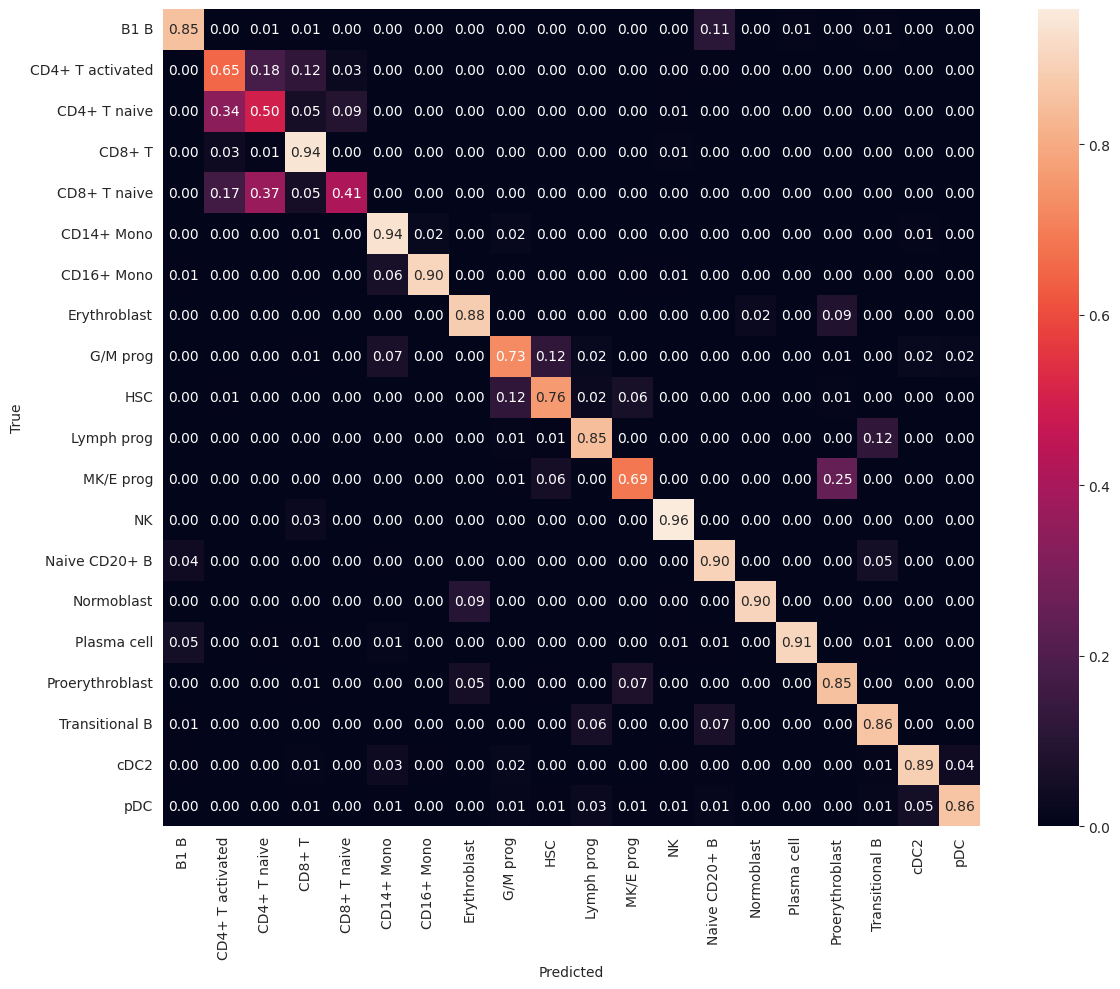

In [27]:
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=celltypes)
# plt.figure(figsize=(10,10))
# disp.plot(xticks_rotation='vertical', values_format='.1f', include_values=False, cmap='viridis')
# plt.tight_layout()
# plt.show()
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=celltypes, yticklabels=celltypes, square=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show(block=False)
fig.savefig('confusion_percelltype_novel.pdf')

In [16]:
scoreX.sum().item()

17513.0

<AxesSubplot: >

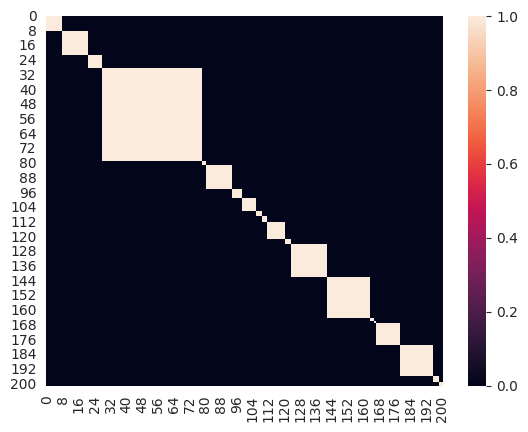

In [28]:
sns.heatmap(mask[::100, ::100].numpy())

<AxesSubplot: >

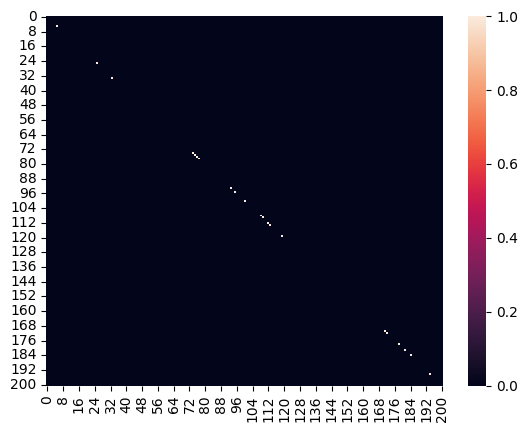

In [27]:
sns.heatmap(scoreX[::100, ::100].numpy())

<AxesSubplot: >

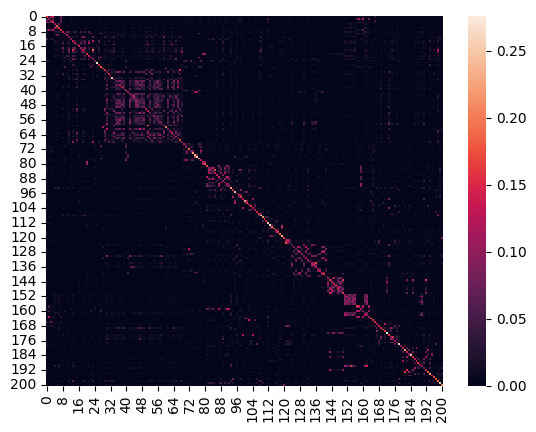

In [49]:
sns.heatmap(torch.pow(Xsoft[::100, ::100], 0.15).numpy())

In [86]:
best = 0
for p in torch.arange(0.05, 2, 0.05):
    print(p)
    X=torch.pow(Xsoft, p)
    # Xsoft = X
    print(X.sum())
    X = X.clip(min=0)
    print(X.sum())
    mx = torch.max(X, dim=0, keepdim=True).values
    # X = (mx == X).float()   # convert to a hard matching
    logits_row_sums = X.sum(dim=0)
    print(logits_row_sums)
    X = torch.div(X, logits_row_sums)
    print(X.shape, X.sum().item())

    scoreX = X.mul(mask)
    print(scoreX.sum())

    cell_type_score = scoreX.sum() / scoreX.shape[0]

    print("Cell type matching competition score", cell_type_score.item())
    if cell_type_score.item() > best:
        best = cell_type_score.item()
        best_p = p
        print("best p:", best_p)

tensor(0.0500)
tensor(27572980.)
tensor(27572980.)
tensor([1498.7343, 1635.4819, 1284.8839,  ..., 1262.7079, 1537.0548,
        1625.6678])
torch.Size([20009, 20009]) 20009.0
tensor(4374.6670)
Cell type matching competition score 0.2186349630355835
best p: tensor(0.0500)
tensor(0.1000)
tensor(6184110.)
tensor(6184110.)
tensor([348.3582, 335.8457, 266.3200,  ..., 243.2453, 351.6774, 395.4825])
torch.Size([20009, 20009]) 20009.0
tensor(6520.8364)
Cell type matching competition score 0.32589516043663025
best p: tensor(0.1000)
tensor(0.1500)
tensor(1672612.2500)
tensor(1672612.2500)
tensor([ 91.2192,  78.2301,  66.3916,  ...,  52.5882,  87.5437, 104.0528])
torch.Size([20009, 20009]) 20009.0
tensor(8988.5605)
Cell type matching competition score 0.44922587275505066
best p: tensor(0.1500)
tensor(0.2000)
tensor(535506.6250)
tensor(535506.6250)
tensor([26.8581, 20.9871, 19.9295,  ..., 13.0128, 24.0090, 29.6077])
torch.Size([20009, 20009]) 20009.0
tensor(11299.0137)
Cell type matching competiti

In [ ]:
import seaborn as sns
sns.heatmap(scoreX.numpy())